## The Models

### Imports and global variables

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

plt.style.use('fivethirtyeight')
%matplotlib inline

path = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/projects/capstone/data/'

#### Load the data

In [5]:
# load training data
df = pd.read_csv(path + 'df.csv')
del df['Unnamed: 0']
#del df['Unnamed: 0.1']

# load held-out testing data
df_test = pd.read_csv(path + 'df_test.csv')
del df_test['Unnamed: 0']
df.shape
df_test.shape

In [12]:
# subset the data
sf = df[df['sci_fi']==1]
rm = df[df['sci_fi']==0]
sfbs = df[((df['best_seller']==1) & (df['sci_fi']==1))]
rmbs = df[((df['best_seller']==1) & (df['sci_fi']==0))]
sff = df[((df['best_seller']==0) & (df['sci_fi']==1))]
rmf = df[((df['best_seller']==0) & (df['sci_fi']==0))]


sf_test= df_test[df_test['sci_fi']==1]
rm_test= df_test[df_test['sci_fi']==0]
sfbs_test = df_test[((df_test['best_seller']==1) & (df_test['sci_fi']==1))]
rmbs_test= df_test[((df_test['best_seller']==1) & (df_test['sci_fi']==0))]
sff_test= df_test[((df_test['best_seller']==0) & (df_test['sci_fi']==1))]
rmf_test= df_test[((df_test['best_seller']==0) & (df_test['sci_fi']==0))]

### Random forest logistic classification

#### Science-fiction

In [67]:
# y_sf = sf['best_seller']
# X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 
#            'profane', 'conj_coord', 'number','determiner', 'exist_there', 'foreign_word', 'conj_sub_prep', 'adj',
#            'adj_compare', 'adj_sup', 'verb_aux', 'noun', 'noun_prop','noun_prop_pural', 'noun_plural', 'predeterm', 
#            'pronoun_pers','pronoun_poss', 'adv', 'adv_compare', 'adv_sup', 'adv_part','inf_to', 'interject', 
#            'verb_base', 'verb_past', 'verb_ger','verb_pp', 'verb_sing_pres', 'verb_3rd_sing_pres', 'wh_determ',
#            'wh_pronoun', 'wh_poss', 'wh_adv', 'poss_ending', 'symbol']]

# y_sf_test = sf_test['best_seller']
# X_sf_test = sf_test[['avg_sent_len','avg_word_len', 'lex_diversity', 'polarity','subjectivity',  
#            'profane', 'conj_coord', 'number','determiner', 'exist_there', 'foreign_word', 'conj_sub_prep', 'adj',
#            'adj_compare', 'adj_sup', 'verb_aux', 'noun', 'noun_prop','noun_prop_pural', 'noun_plural', 'predeterm', 
#            'pronoun_pers','pronoun_poss', 'adv', 'adv_compare', 'adv_sup', 'adv_part','inf_to', 'interject', 
#            'verb_base', 'verb_past', 'verb_ger','verb_pp', 'verb_sing_pres', 'verb_3rd_sing_pres', 'wh_determ',
#            'wh_pronoun', 'wh_poss', 'wh_adv', 'poss_ending', 'symbol']]

# print y_sf.shape, X_sf.shape
# print y_sf_test.shape, X_sf_test.shape

(39,) (39, 41)
(8,) (8, 41)


In [80]:
y_sf = sf['best_seller']
X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane']]

y_sf_test = sf_test['best_seller']
X_sf_test = sf_test[['avg_sent_len','avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane']]

print y_sf.shape, X_sf.shape
print y_sf_test.shape, X_sf_test.shape

(39,) (39, 6)
(8,) (8, 6)


In [81]:
dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X_sf, y_sf)
dtc_scores = cross_val_score(dtc, X_sf, y_sf, cv=5)

print dtc_scores, np.mean(dtc_scores)

[ 0.875       0.625       0.375       0.625       0.57142857] 0.614285714286


In [82]:
dctc = DecisionTreeClassifier()

# search params
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10]
}

# gridsearch    
dtc_gs = GridSearchCV(dctc, dtc_params, n_jobs=-1, cv=5, verbose=1)
dtc_gs.fit(X_sf, y_sf)
dtc_best_estimator = dtc_gs.best_estimator_

print "Best estimator", dtc_best_estimator

print 
dct_best_param = dtc_gs.best_params_
print "Best parameters",  dct_best_param 

print 
print "Best score", dtc_gs.best_score_

In [105]:
# predict from test data
y_sf_pred= dtc_gs.predict(X_sf_test)
print y_sf_pred.shape, y_sf_test.shape

(8,) (8,)


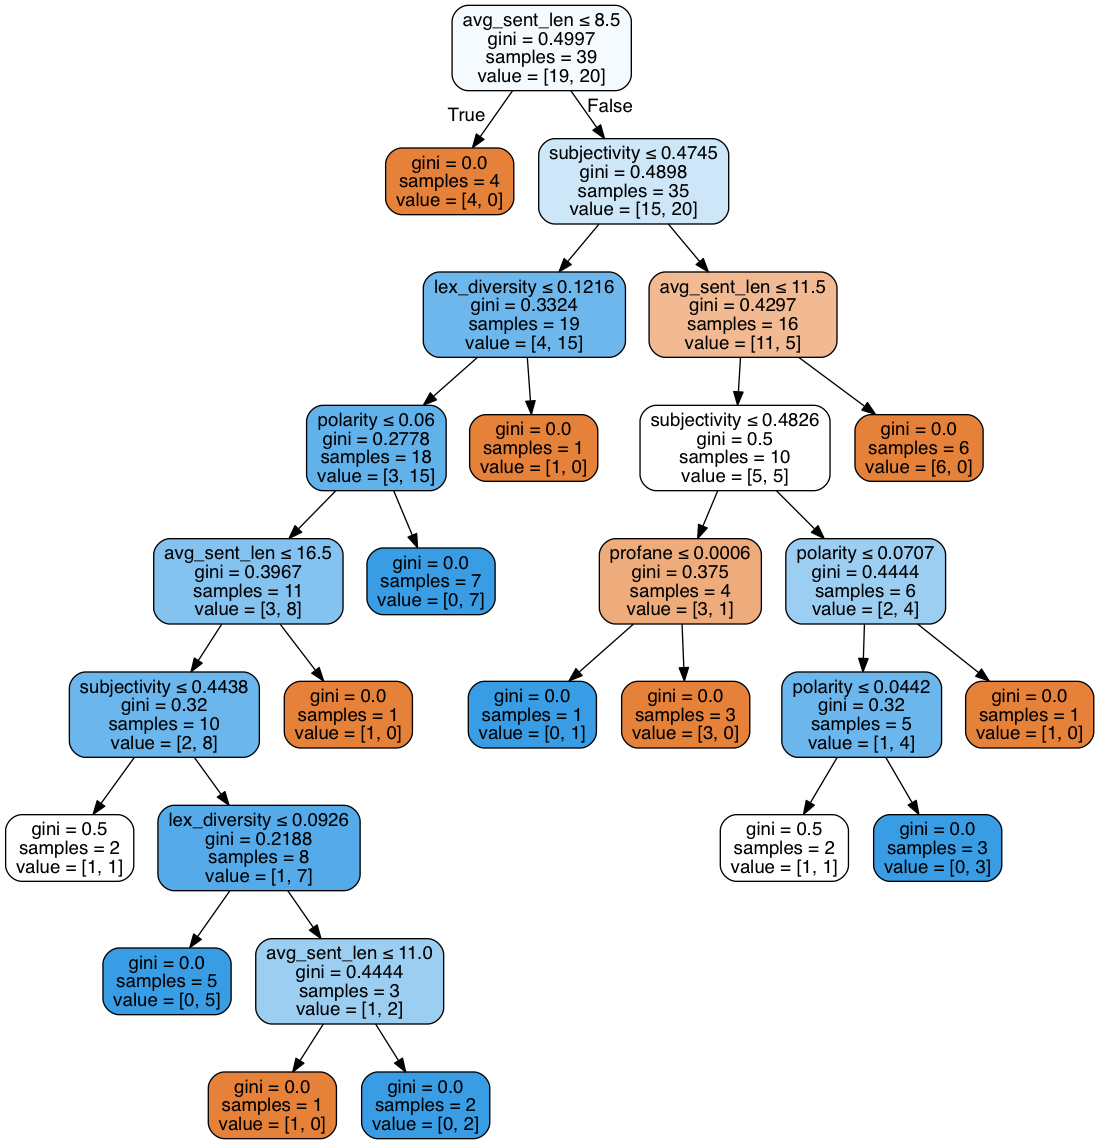

In [85]:
dot_data = StringIO()

# use best parameters found above
dctc_best= DecisionTreeClassifier(max_features='sqrt', min_samples_split=3, max_depth=None)
dctc_best.fit(X_sf, y_sf)

# graph
export_graphviz(dctc_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_sf.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [86]:
# print feature importances
feature_importance = pd.DataFrame({ 'feature':X_sf.columns, 
                                   'importance':dctc_best.feature_importances_
})

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance

,feature,importance
0,avg_sent_len,0.384069
4,subjectivity,0.299385
3,polarity,0.131698
2,lex_diversity,0.099070
5,profane,0.085777
1,avg_word_len,0.000000


In [87]:
class_rpt = classification_report(y_sf_test, y_sf_pred)
print class_rpt 

             precision    recall  f1-score   support

          0       0.60      0.75      0.67         4
          1       0.67      0.50      0.57         4

avg / total       0.63      0.62      0.62         8



#### Romance

In [89]:
y_rm = rm['best_seller']
X_rm = rm[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane']]

y_rm_test = rm_test['best_seller']
X_rm_test = rm_test[['avg_sent_len','avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane']]

print y_rm.shape, X_rm.shape
print y_rm_test.shape, X_rm_test.shape

(38,) (38, 6)
(3,) (3, 6)


In [102]:
dtc_rm = DecisionTreeClassifier(max_depth=4)
dtc_rm.fit(X_rm, y_rm)
dtc_rm_scores = cross_val_score(dtc_rm, X_rm, y_rm, cv=5)

print dtc_rm_scores, np.mean(dtc_rm_scores)

[ 0.625       0.5         0.75        0.57142857  0.71428571] 0.632142857143


In [103]:
dctc_rm = DecisionTreeClassifier()

# search params
dtc_rm_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10]
}

# gridsearch    
dtc_rm_gs = GridSearchCV(dctc_rm, dtc_rm_params, n_jobs=-1, cv=5, verbose=1)
dtc_rm_gs.fit(X_rm, y_rm)
dtc_rm_best_estimator = dtc_rm_gs.best_estimator_

print "Best estimator", dtc_rm_best_estimator

print 
dct_rm_best_param = dtc_rm_gs.best_params_
print "Best parameters",  dct_rm_best_param 

print 
print "Best score", dtc_rm_gs.best_score_

Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.8s


Best estimator DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Best parameters {'max_features': 'sqrt', 'min_samples_split': 5, 'max_depth': 3}

Best score 0.736842105263


[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed:    2.8s finished


In [104]:
# predict from test data
y_rm_pred= dtc_rm_gs.predict(X_rm_test)
print y_rm_pred.shape, y_rm_test.shape

(3,) (3,)


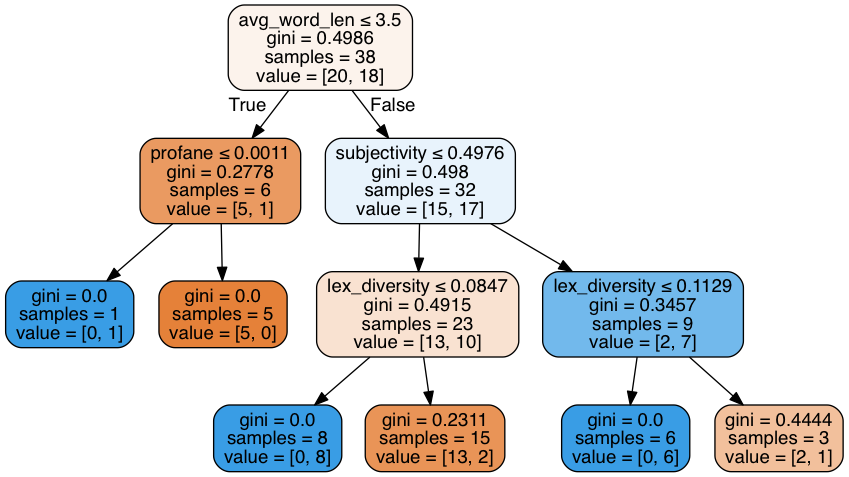

In [106]:
dot_data = StringIO()

# use best parameters found above
dctc_rm_best= DecisionTreeClassifier(max_features='sqrt', min_samples_split=5, max_depth=3)
dctc_rm_best.fit(X_rm, y_rm)

# graph
export_graphviz(dctc_rm_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_rm.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [107]:
# print feature importances
feature_importance_rm = pd.DataFrame({ 'feature':X_rm.columns, 
                                   'importance':dctc_rm_best.feature_importances_
})

feature_importance_rm.sort_values('importance', ascending=False, inplace=True)
feature_importance_rm

,feature,importance
2,lex_diversity,0.679664
5,profane,0.117808
4,subjectivity,0.107585
1,avg_word_len,0.094944
0,avg_sent_len,0.000000
3,polarity,0.000000


In [110]:
class_rpt_rm = classification_report(y_rm_test, y_rm_pred)
print class_rpt_rm

             precision    recall  f1-score   support

          0       0.67      1.00      0.80         2
          1       0.00      0.00      0.00         1

avg / total       0.44      0.67      0.53         3

